In [1]:
import os
import logging
import re
from pprint import pprint
from glob import glob

import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from scipy.special import softmax
from matplotlib import pyplot as plt
import seaborn as sns

from simpletransformers.classification import ClassificationModel, ClassificationArgs

In [2]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

## Prepare datasets

In [3]:
def clean_text(text):
    user_re = r"(@[\w]+)"
    link_re = r"(https?:\/\/\S+)"
    text = re.sub(user_re, "", text) # remove user tags
    text = re.sub(link_re, "", text) # remove links
    text = text.lower()
    return text

def load_hasoc_dataset(path):
    data_df = pd.read_csv(path, sep="\t")

    try: del data_df["text_id"]
    except: pass

    try: del data_df["task_2"]
    except: pass

    try: del data_df["task_3"]
    except: pass

    data_df.columns = ["text", "labels"]
    data_df["text"] = data_df["text"].map(clean_text)

    return data_df

train_en_df = load_hasoc_dataset("/hdd/matjazibb/dataset/hasoc_2019/english/english_dataset/english_dataset.tsv")
test_en_df = load_hasoc_dataset("/hdd/matjazibb/dataset/hasoc_2019/english/english_dataset/hasoc2019_en_test-2919.tsv")

train_de_df = load_hasoc_dataset("/hdd/matjazibb/dataset/hasoc_2019/german/german_dataset/german_dataset.tsv")
test_de_df = load_hasoc_dataset("/hdd/matjazibb/dataset/hasoc_2019/german/german_dataset/hasoc_de_test_gold.tsv")

train_hi_df = load_hasoc_dataset("/hdd/matjazibb/dataset/hasoc_2019/hindi/hindi_dataset/hindi_dataset.tsv")
test_hi_df = load_hasoc_dataset("/hdd/matjazibb/dataset/hasoc_2019/hindi/hindi_dataset/hasoc2019_hi_test_gold_2919.tsv")

train_ml_df = pd.concat([train_en_df, train_de_df, train_hi_df])
test_ml_df = pd.concat([test_en_df, test_de_df, test_hi_df])

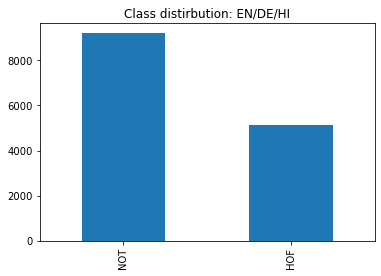

In [4]:
def plot_class_hist(data_df, title):
    data_df["labels"].value_counts().plot(kind="bar", title=f"Class distirbution: {title}")

plot_class_hist(train_ml_df, "EN/DE/HI")

## Train BERT models

In [5]:
def get_bert_model(model_name, hf_model_type, hf_model_name, class_weights=None):
    model_args = ClassificationArgs()
    model_args.output_dir=f"/hdd/matjazibb/outputs/{model_name}"
    model_args.best_model_dir=f"{model_args.output_dir}/best_model"
    model_args.cache_dir=f"/hdd/matjazibb/cache_dir/{model_name}"
    model_args.tensorboard_dir=f"/hdd/matjazibb/runs/{model_name}"

    # Training HP
    model_args.num_train_epochs = 1
    model_args.learning_rate = 1e-4
    model_args.train_batch_size = 64
    model_args.weight_decay = 1e-4

    # Dataset
    model_args.labels_list = ["HOF", "NOT"]

    # Evaluation
    model_args.evaluate_during_training = False
    model_args.evaluate_each_epoch = False

    # Outputs & cache
    model_args.save_model_every_epoch = True
    model_args.save_steps = -1
    model_args.overwrite_output_dir = True

    need_training = not os.path.exists(model_args.output_dir)
    pretrained_model_name = hf_model_name if need_training else model_args.output_dir

    return need_training, ClassificationModel(
        hf_model_type, pretrained_model_name,
        args=model_args,
        use_cuda=True,
        cuda_device=0,
        num_labels=2,
        weight=class_weights
    )

In [6]:
need_training, bert_en_model = get_bert_model(
    "bert_en",
    "bert",
    "bert-base-uncased",
    class_weights = compute_class_weight('balanced', np.unique(train_en_df["labels"]), train_en_df["labels"]).tolist()
)

if need_training:
    bert_en_model.train_model(train_en_df)

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=['HOF' 'NOT'], y=0       NOT
1       HOF
2       NOT
3       NOT
4       NOT
       ... 
5847    HOF
5848    NOT
5849    HOF
5850    HOF
5851    HOF
Name: labels, Length: 5852, dtype: object as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [7]:
need_training, bert_ml_model = get_bert_model(
    "bert_ml",
    "bert",
    "bert-base-uncased",
    class_weights = compute_class_weight('balanced', np.unique(train_ml_df["labels"]), train_ml_df["labels"]).tolist()
)

if need_training:
    bert_ml_model.train_model(train_ml_df)

/home/matjazibb/miniconda3/envs/nlp/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=['HOF' 'NOT'], y=0       NOT
1       HOF
2       NOT
3       NOT
4       NOT
       ... 
4660    NOT
4661    HOF
4662    NOT
4663    HOF
4664    HOF
Name: labels, Length: 14336, dtype: object as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [8]:
need_training, mbert_en_model = get_bert_model(
    "mbert_en",
    "bert",
    "bert-base-multilingual-uncased",
    class_weights = compute_class_weight('balanced', np.unique(train_en_df["labels"]), train_en_df["labels"]).tolist()
)

if need_training:
    mbert_en_model.train_model(train_en_df)

In [9]:
need_training, mbert_ml_model = get_bert_model(
    "mbert_ml",
    "bert",
    "bert-base-multilingual-uncased",
    class_weights = compute_class_weight('balanced', np.unique(train_ml_df["labels"]), train_ml_df["labels"]).tolist()
)

if need_training:
    mbert_ml_model.train_model(train_ml_df)

## Evaluate BERT models

In [10]:
def eval_model(model, data_df):
    y_hat, p_hat = model.predict(data_df["text"].tolist())
    p_hat = softmax(p_hat, axis=1)[:,0]

    f1 = sklearn.metrics.f1_score(data_df["labels"], y_hat, pos_label="HOF")
    fpr, tpr, t = sklearn.metrics.roc_curve(data_df["labels"], p_hat, pos_label="HOF")
    roc_auc = sklearn.metrics.auc(fpr, tpr)

    return f1, roc_auc, fpr, tpr

In [11]:
eval_models = [
    ("BERT-en-en", bert_en_model, test_en_df),
    ("BERT-en-de", bert_en_model, test_de_df),
    ("BERT-en-hi", bert_en_model, test_hi_df),
    ("BERT-en-ml", bert_en_model, test_ml_df),

    ("ML-BERT-en-en", mbert_en_model, test_en_df),
    ("ML-BERT-en-de", mbert_en_model, test_de_df),
    ("ML-BERT-en-hi", mbert_en_model, test_hi_df),
    ("ML-BERT-en-ml", mbert_en_model, test_ml_df),

    ("BERT-ml-en", bert_ml_model, test_en_df),
    ("BERT-ml-de", bert_ml_model, test_de_df),
    ("BERT-ml-hi", bert_ml_model, test_hi_df),
    ("BERT-ml-ml", bert_ml_model, test_ml_df),

    ("ML-BERT-ml-en", mbert_ml_model, test_en_df),
    ("ML-BERT-ml-de", mbert_ml_model, test_de_df),
    ("ML-BERT-ml-hi", mbert_ml_model, test_hi_df),
    ("ML-BERT-ml-ml", mbert_ml_model, test_ml_df),
]

results = []

for model_name, model, data_df in eval_models:
    f1, roc_auc, fpr, tpr = eval_model(model, data_df)
    results += [(model_name, f1, roc_auc, fpr, tpr)]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.



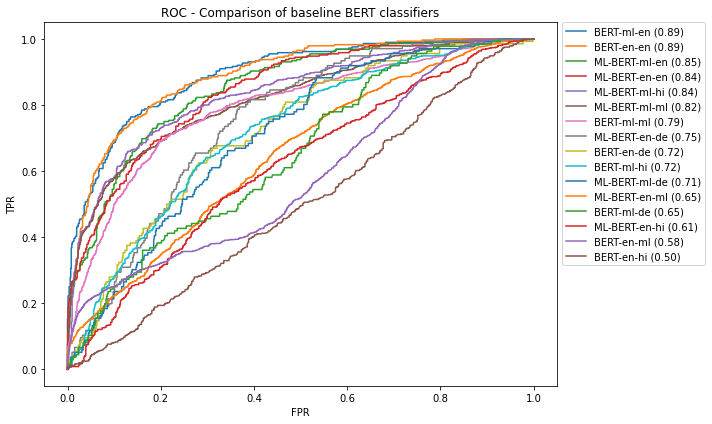

In [12]:
plt.figure(figsize=(10,6))
for model_name, f1, roc_auc, fpr, tpr in sorted(results, key=lambda x: x[2], reverse=True):
    plt.plot(fpr, tpr, label=f"{model_name} ({roc_auc:.2f})")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - Comparison of baseline BERT classifiers")
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.tight_layout()